In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Load Wikipedia dataset
We will be using the dataset of abridged Wikipedia pages. Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).

In [61]:
wiki = pd.read_csv('people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [62]:
# If you want to check whether the text on the webpage agrees with the one here, you can display it with the following code:

from IPython.display import HTML
print(wiki['text'][0])
# HTML(url=wiki['URI'][0])

digby morrell born 10 october 1979 is a former australian rules footballer who played with the kangaroos and carlton in the australian football league aflfrom western australia morrell played his early senior football for west perth his 44game senior career for the falcons spanned 19982000 and he was the clubs leading goalkicker in 2000 at the age of 21 morrell was recruited to the australian football league by the kangaroos football club with its third round selection in the 2001 afl rookie draft as a forward he twice kicked five goals during his time with the kangaroos the first was in a losing cause against sydney in 2002 and the other the following season in a drawn game against brisbaneafter the 2003 season morrell was traded along with david teague to the carlton football club in exchange for corey mckernan he played 32 games for the blues before being delisted at the end of 2005 he continued to play victorian football league vfl football with the northern bullants carltons vflaf

## Ex. 1: Extract word count vectors
As we have seen in Assignment 4, we can extract word count vectors using `CountVectorizer` function.
- make sure you include words of unit length by using the parameter: `token_pattern=r"(?u)\b\w+\b"`
- do not use any stopwords
- take 10000 most frequent words in the corpus
- explicitly take all the words independent of in how many documents they occur
- obtain the matrix of word counts

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    token_pattern=r"(?u)\b\w+\b", 
    max_features=10000, 
    stop_words=None)

txt = wiki["text"]

WCmatrix = vectorizer.fit_transform(txt)

## Ex. 2: Find nearest neighbors
**a)** Start by finding the nearest neighbors of the Barack Obama page using the above word count matrix to represent the articles and **Euclidean** distance to measure distance. \
Save the distances in `wiki['BO-eucl']` and look at the top 10 nearest neighbors.

In [64]:
# One can use the following:
    # from sklearn.neighbors import NearestNeighbors
    # nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute',metric='euclidean').fit(X.toarray())
    # distances, indices = nbrs.kneighbors(X.toarray())
    
# but here let's use:
from sklearn.metrics import pairwise_distances

vec_obama = WCmatrix[wiki[wiki["name"]=="Barack Obama"].index]
dist = pairwise_distances(vec_obama, WCmatrix , metric='euclidean')
wiki['BO-eucl'] = np.transpose(dist)
sort_wiki = wiki.sort_values(by=['BO-eucl'])
sort_wiki.head(10)

,URI,name,text,BO-eucl
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,0.000000
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,31.336879
28447,<http://dbpedia.org/resource/George_W._Bush>,George W. Bush,george walker bush born july 6 1946 is an amer...,33.645208
48202,<http://dbpedia.org/resource/Tony_Vaccaro>,Tony Vaccaro,michelantonio celestino onofrio vaccaro born d...,33.734256
14754,<http://dbpedia.org/resource/Mitt_Romney>,Mitt Romney,willard mitt romney born march 12 1947 is an a...,34.351128
31423,<http://dbpedia.org/resource/Walter_Mondale>,Walter Mondale,walter frederick fritz mondale born january 5 ...,34.423829
36364,<http://dbpedia.org/resource/Don_Bonker>,Don Bonker,don leroy bonker born march 7 1937 in denver c...,34.597688
13229,<http://dbpedia.org/resource/Francisco_Barrio>,Francisco Barrio,francisco javier barrio terrazas born november...,34.669872
35357,<http://dbpedia.org/resource/Lawrence_Summers>,Lawrence Summers,lawrence henry larry summers born november 30 ...,35.383612
25258,<http://dbpedia.org/resource/Marc_Ravalomanana>,Marc Ravalomanana,marc ravalomanana malagasy ravalumanan born 12...,35.440090


**b)** Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [65]:
dst = pairwise_distances(WCmatrix[wiki[(wiki.name == "Barack Obama") | (wiki.name == "Joe Biden") | (wiki.name == "George W. Bush")].index])
print("Distance between Barack Obama and Joe Biden: ", dst[0,1])
print("Distance between Barack Obama and George W. Bush: ", dst[0,2])
print("Distance between Joe Biden and George W. Bush: ", dst[1,2])

Distance between Barack Obama and Joe Biden:  30.919249667480614
Distance between Barack Obama and George W. Bush:  31.336879231984796
Distance between Joe Biden and George W. Bush:  33.645207682521445


## Summary:
As we can observe the smallest pairwise distance is between Joe Biden and Barack Obama.

All of the 10 people from **a)** are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians, e.g.,

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

**c)** Let's find out why Francisco Barrio was considered a close neighbor of Obama.
To do this, look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

In [66]:
def top_words(name):
    df = pd.DataFrame(wiki[wiki["name"] == name]["text"].values[0].split(), columns=["word"])
    words_count = df["word"].value_counts()
    df = words_count.to_frame("count")
    return df.sort_values(by='count',ascending=False)

In [67]:
# Top words from Barack Obama page
obama_words = top_words('Barack Obama')
obama_words.head(20)

,count
the,40
in,30
and,21
of,18
to,14
his,11
obama,9
act,8
a,7
he,7


In [68]:
# Top words from Francisco Barrio
barrio_words = top_words('Francisco Barrio')
barrio_words.head(20)


,count
the,36
of,24
and,18
in,17
he,10
to,9
chihuahua,7
governor,6
a,6
his,5


# Summary:
Some words like: "the", "in", "and", "of", "to" are very popular in both texts on Barack Obama and Francisco Barrio pages.

**d)** Extract the list of most frequent **common** words that appear in both Obama's and Barrio's documents and display the five words that appear most often in Barrio's article.

Use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the index column of words). See [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) for more details.

In [69]:
# Modify the code to avoid error.

common_words = obama_words.join(barrio_words,lsuffix='_obama', rsuffix='_barrio')
common_words.sort_values(by='count_barrio', ascending=False).head(5)

,count_obama,count_barrio
the,40,36.0
of,18,24.0
and,21,18.0
in,30,17.0
he,7,10.0


Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page. 

In [70]:
bush_words = top_words('George W. Bush')
# Modify the code to avoid error.
obama_words_mod = obama_words.drop('obama')
o_w = obama_words_mod.join(bush_words,lsuffix='_obama', rsuffix='_bush')
o_w.sort_values(by='count_obama', ascending=False).head(10)

,count_obama,count_bush
the,40,39.0
in,30,22.0
and,21,14.0
of,18,14.0
to,14,11.0
his,11,6.0
act,8,3.0
he,7,8.0
a,7,6.0
as,6,6.0


**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

**e)** Among the words that appear in both Barack Obama and Francisco Barrio, take the 15 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [71]:
# wiki[articles]['name']

In [122]:
# It might be helpful to use:
word_to_ind={v: i for i, v in enumerate(vectorizer.get_feature_names_out())} # a dictionary with words as keys and indices as values

# Your code goes here]
sum_articles = 0
c_w = obama_words.join(barrio_words,lsuffix='_obama', rsuffix='_barrio')
c_w.dropna(inplace=True)
c_w_sort = c_w.sort_values(by="count_obama", ascending=False).iloc[:15]

for i in range(0,len(wiki["text"])):
    hasword = 1
    for word in c_w_sort.index:
        if word_to_ind[word] not in WCmatrix[i].nonzero()[1]:
            hasword=0
    if hasword == 1: 
        print( wiki["name"][i])
        sum_articles += 1
print("All of those 15 words are in ", sum_articles, " articles.") 

Donald Fowler
Chris Redfern
James Bilbray
Paul Kagame
Bernard Kenny
Paul Sarlo
Gy%C3%B6rgy Sur%C3%A1nyi
Morley Winograd
David Ibarra Mu%C3%B1oz
Francisco Barrio
Charles Taylor (Liberian politician)
Jesse Ventura
Joe Biden
George W. Bush
Arturo Vallarino
John O. Agwunobi
Jimmy Carter
Barack Obama
Bill Clinton
John Garamendi
Helmut Anheier
Edward Rowny
Henry Sanders (Alabama politician)
Saber Hossain Chowdhury
Russell Trood
Robert Lewis Morgan
Ewart Brown
Chuck Wolfe (executive)
Lokman Singh Karki
Hu Jintao
All of those 15 words are in  30  articles.


## Ex. 3: TF-IDF to the rescue
Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons.

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.

**a)** Repeat the search for the 10 nearest neighbors of Barack Obama with Euclidean distance of TF-IDF. This time do not limit to only 10000 most frequent words, but take all of them.

In [504]:
#  We could use:
    # from sklearn.feature_extraction.text import TfidfVectorizer
# but since we already know how to compute CountVectorizer, let's use:
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(
    token_pattern = r"(?u)\b\w+\b",
    stop_words = None)

WCmatrix = vectorizer.fit_transform(wiki["text"])

tfidf = TfidfTransformer(smooth_idf = False, norm = None)
TFIDFmatrix = tfidf.fit_transform(WCmatrix)


In [124]:
# now recompute the distances as before but for TF-IDF

dist = pairwise_distances(TFIDFmatrix[wiki[wiki.name == "Barack Obama"].index], TFIDFmatrix, metric='euclidean')

# add the distances as a column in the wiki dataframe
wiki['BO-eucl-TF-IDF'] = np.transpose(dist)
sort_wiki = wiki.sort_values(by=['BO-eucl-TF-IDF'])
sort_wiki.head(10)

,URI,name,text,BO-eucl,BO-eucl-TF-IDF
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,0.000000,0.000000
38376,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an ir...,42.544095,139.364493
46811,<http://dbpedia.org/resource/Jeff_Sessions>,Jeff Sessions,jefferson beauregard jeff sessions iii born de...,46.518813,139.757740
7914,<http://dbpedia.org/resource/Phil_Schiliro>,Phil Schiliro,phil schiliro is an american political consult...,52.402290,139.812175
38714,<http://dbpedia.org/resource/Eric_Stern_(polit...,Eric Stern (politician),eric stern is the director of operations for t...,45.310043,140.450064
6507,<http://dbpedia.org/resource/Bob_Menendez>,Bob Menendez,robert bob menendez born january 1 1954 is the...,46.936127,141.661111
44681,<http://dbpedia.org/resource/Jesse_Lee_(politi...,Jesse Lee (politician),jesse lee born 1979 was named the white house ...,51.097945,142.342440
6796,<http://dbpedia.org/resource/Eric_Holder>,Eric Holder,eric himpton holder jr born january 21 1951 is...,47.106263,142.490179
38495,<http://dbpedia.org/resource/Barney_Frank>,Barney Frank,barnett barney frank born march 31 1940 is an ...,45.705580,142.581337
56008,<http://dbpedia.org/resource/Nathan_Cullen>,Nathan Cullen,nathan cullen mp born july 13 1972 is a canadi...,47.233463,142.751073


Let's determine whether this list makes sense.
* With a notable exception of Nathan Cullen, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, Eric Stern, Eric Holder worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document.

**b)** Sort the words in Obama's article by their TF-IDF weights; do the same for Schiliro's article as well.
Using the **join** operation we learned earlier, compute the common words shared by Obama's and Schiliro's articles.
Sort the common words by their TF-IDF weights in Obama's document.

In [378]:
def top_words_tf_idf(name):
    """
    Get a table of the largest tf-idf words in the given person's wikipedia page.
    """
    # Your code goes 
    words = wiki[wiki["name"] == name]["text"].values[0].split()
    word_to_ind_tfidf={v: i for i, v in enumerate(vectorizer.get_feature_names_out())}
    indexwiki = wiki[wiki.name == name].index
    data = [TFIDFmatrix[indexwiki][0,word_to_ind_tfidf[i]] for i in words]
    df = pd.DataFrame(data,words,columns=["tf-idf"])
    df.drop_duplicates(inplace=True)
    return df.sort_values(by='tf-idf',ascending=False)


In [379]:
# Top words in Schiliro's article by TF-IDF weights:
schiliro_words = top_words_tf_idf('Phil Schiliro')
schiliro_words

# Top words in Obama's article by TF-IDF weights:

obama_words = top_words_tf_idf('Barack Obama')
obama_words

,tf-idf
obama,52.295653
the,40.004063
act,35.678223
in,30.028962
iraq,21.747379
...,...
is,2.055233
new,1.887235
which,1.767431
that,1.661407


**c)** Among the words that appear in both Barack Obama and Phil Schiliro, take the 15 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [380]:
# Let's compute common words shared by both pages using join operation.
comm_words = obama_words.join(schiliro_words,lsuffix='_obama', rsuffix='_schiliro')

# We want to sort common words by their TF-IDF weights in Obama's document.
comm_words.dropna(inplace=True)
comm_words_sort = comm_words.sort_values(by='tf-idf_obama', ascending=False).iloc[:15]
print(comm_words_sort)

              tf-idf_obama  tf-idf_schiliro
obama            52.295653        11.621256
the              40.004063        10.001016
in               30.028962         5.004827
and              21.015648         6.004471
law              20.722936        10.361468
of               18.074811         9.037406
democratic       16.410689         8.205344
to               14.657229         7.328615
his              13.888726         1.262611
senate           13.164288         4.388096
president        11.226869        14.033587
presidential      9.386955         4.693478
he                8.493580        13.347054
states            8.473201         2.824400
2011              8.107041         5.404694


In [382]:

# It might be helpful to use:
word_to_ind={v: i for i, v in enumerate(vectorizer.get_feature_names_out())} # a dictionary with words as keys and indices as values

# Your code goes here]
sum_articles = 0
# c_w = obama_words.join(barrio_words,lsuffix='_obama', rsuffix='_barrio')
c_w = comm_words


for i in range(0,len(wiki["text"])):
    hasword = 1
    for word in c_w.index:
        if word_to_ind[word] not in WCmatrix[i].nonzero()[1]:
            hasword=0
    if hasword == 1: 
        print( wiki["name"][i])
        sum_articles += 1

Phil Schiliro
Barack Obama


## Summary:
This time there is less articles containing our chosen words. That is because it's much easier to have words such as "a" or "as" in common. 

## Ex. 4: Choosing metrics
**a)** Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [388]:

vec_obama = TFIDFmatrix[wiki[wiki["name"]=="Barack Obama"].index]
vec_biden = TFIDFmatrix[wiki[wiki["name"]=="Joe Biden"].index]
dist_tfidf = pairwise_distances(vec_obama, vec_biden , metric='euclidean')
dist_tfidf

array([[148.77845413]])

The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [389]:
wiki.sort_values(by='BO-eucl-TF-IDF',ascending=True)[['name','BO-eucl-TF-IDF']][0:10]

,name,BO-eucl-TF-IDF
35817,Barack Obama,0.000000
38376,Samantha Power,139.364493
46811,Jeff Sessions,139.757740
7914,Phil Schiliro,139.812175
38714,Eric Stern (politician),140.450064
6507,Bob Menendez,141.661111
44681,Jesse Lee (politician),142.342440
6796,Eric Holder,142.490179
38495,Barney Frank,142.581337
56008,Nathan Cullen,142.751073


But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones.

**b)** Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page. To compute text length use the same splitting rules you used in `vectorizer`.

In [399]:
# tokenizer = # Your code goes here

def compute_length(row):
# Here we could use simply:
    return len(row.split(' '))
#     return len(tokenizer(row['text']))
wiki['length'] = [compute_length(i) for i in wiki["text"]]
nearestlen = wiki.sort_values(by='BO-eucl-TF-IDF',ascending=True)[['name','BO-eucl-TF-IDF',"length"]][0:10]

**c)** To see how these document lengths compare to the lengths of other documents in the corpus, make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

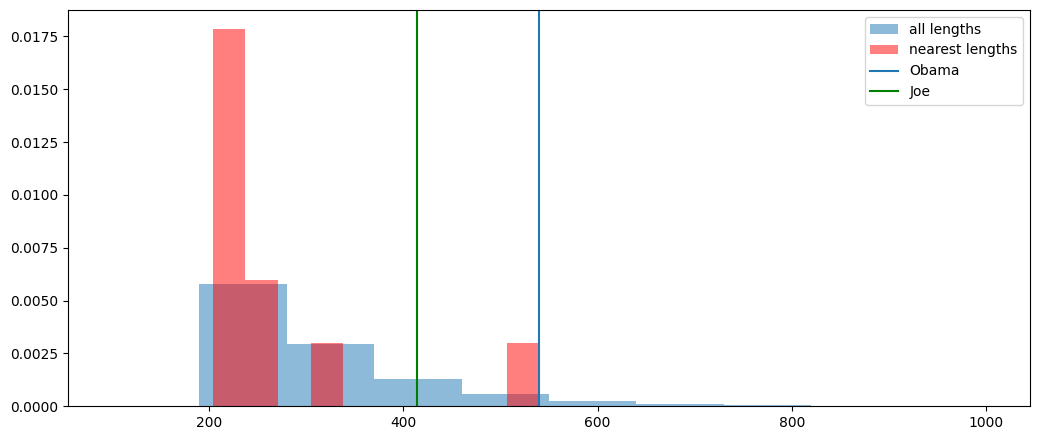

In [466]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki.length , range = [100,1000], alpha=0.5,label = "all lengths",density=True)
plt.hist(nearestlen.length, color = "red", alpha=0.5,label = "nearest lengths",density=True)
plt.axvline(nearestlen.length.values[0],label = "Obama")
plt.axvline(wiki[wiki.name == "Joe Biden"].length.values[0],label = "Joe",color="green")
plt.legend()

plt.tight_layout()
# nearestlen.length.values[0]
# wiki[wiki.name == "Joe Biden"]

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

**d)** Train a new nearest neighbor model, this time with cosine distances.  Then repeat the search for Obama's 100 nearest neighbors and make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

In [485]:
distance_cosine = pairwise_distances(TFIDFmatrix[wiki[wiki.name == "Barack Obama"].index], TFIDFmatrix, metric="cosine")
wiki["distance_cosine"] = distance_cosine.T
nearestcos = wiki.sort_values(by='distance_cosine', ascending=True)[['name', 'length', 'distance_cosine']][0:100]
nearestcos

,name,length,distance_cosine
35817,Barack Obama,540,0.000000
24478,Joe Biden,414,0.572725
57108,Hillary Rodham Clinton,580,0.616149
38376,Samantha Power,310,0.625797
38714,Eric Stern (politician),255,0.651475
...,...,...,...
2045,Allan Ryan (attorney),291,0.731376
47085,Ray Thornton,326,0.731908
16392,P%C3%A9ter Kov%C3%A1cs (lawyer),365,0.732172
55495,Lokman Singh Karki,2486,0.732608


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

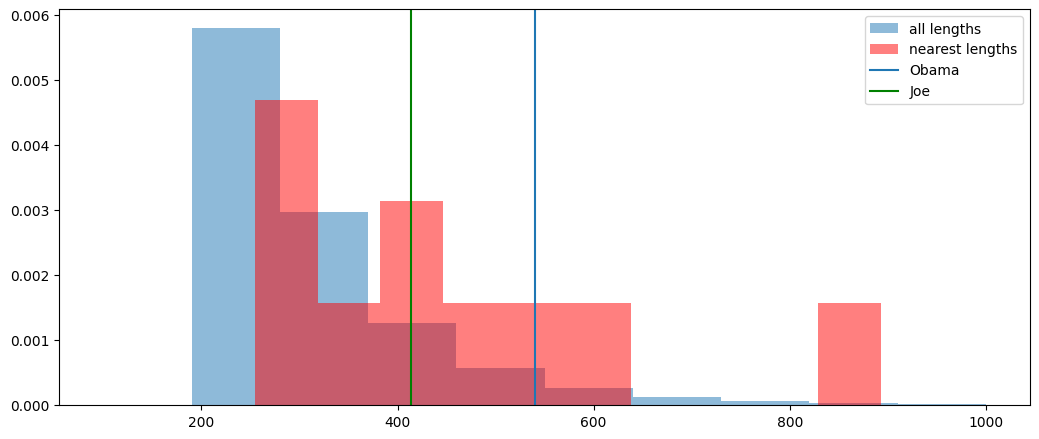

In [499]:

nearestlen = wiki.sort_values(by='distance_cosine',ascending=True)[['name','distance_cosine',"length"]][0:10]
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki.length , range = [100,1000], alpha=0.5,label = "all lengths",density=True)
plt.hist(nearestlen.length, color = "red", alpha=0.5,label = "nearest lengths",density=True)
plt.axvline(nearestlen.length.values[0],label = "Obama")
plt.axvline(wiki[wiki.name == "Joe Biden"].length.values[0],label = "Joe",color="green")
plt.legend()

plt.tight_layout()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

# Summary:
Cosine distances significantly reduced bias towards shorter articles. 

In [503]:
df = pd.DataFrame({'text': ['democratic governments control law in response to popular act']})
wikitweet = wiki.append({'text': 'democratic governments control law in response to popular act'},ignore_index=True)

C:\Users\Użytkownik\AppData\Local\Temp\ipykernel_6072\3641258187.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wikitweet = wiki.append({'text': 'democratic governments control law in response to popular act'},ignore_index=True)
